In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from datetime import datetime
sn.set(rc={'figure.figsize':(9,3)})

%matplotlib inline

## Envíos

In [338]:
envíos = pd.read_csv('envios.txt', sep='|', parse_dates=['fecha'], index_col='fecha')
envíos.head()

,id_pos,unidades_despachadas,cantidad_envios
fecha,,,
2012-08-17,5235,36,1
2012-08-24,4611,48,1
2012-08-24,4645,48,1
2012-08-24,4649,72,1
2012-08-24,4677,72,1


In [339]:
envíos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42434 entries, 2012-08-17 to 2014-11-29
Data columns (total 3 columns):
id_pos                  42434 non-null int64
unidades_despachadas    42434 non-null int64
cantidad_envios         42434 non-null int64
dtypes: int64(3)
memory usage: 1.3 MB


In [340]:
envíos.cantidad_envios.value_counts()

1    42427
2        7
Name: cantidad_envios, dtype: int64

In [341]:
# la cantidad de envíos no parece ser relevante
envíos.drop(columns='cantidad_envios', inplace=True)

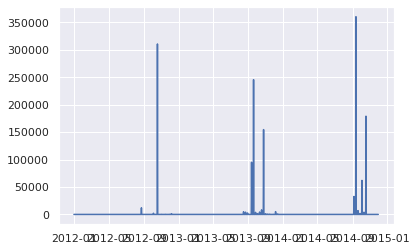

In [344]:
# parece conveniente comenzar desde inicios del 2012 para capturar mejor la periocidad anual
índice = pd.date_range(start='2012-01-01', end='2014-11-30', freq='D')

series = []

for id_pos, grupo in envíos.groupby('id_pos'):
    aux = grupo.groupby(level='fecha').unidades_despachadas.sum()
    aux.name = id_pos
    series.append(aux.reindex(índice))

envíos = pd.concat(series, axis=1).fillna(0)

envíos_agregados = envíos.sum(axis=1)
sn.lineplot(data=envíos_agregados);

## Ventas

In [2]:
ventas = pd.read_csv('ventas.txt', sep='|', parse_dates=['fecha'], index_col=['fecha'])
ventas.tail()

,id_pos,unidades,canal
fecha,,,
2014-11-30,30716,1,ALMACEN
2014-11-30,7911,1,ALMACEN
2014-11-30,9751,1,ALMACEN
2014-11-30,16534,2,ALMACEN
2014-11-30,16553,2,ALMACEN


In [3]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266436 entries, 2012-10-01 to 2014-11-30
Data columns (total 3 columns):
id_pos      266436 non-null int64
unidades    266436 non-null int64
canal       266436 non-null object
dtypes: int64(2), object(1)
memory usage: 8.1+ MB


Detecté puntos de venta duplicados con **distintos canales**. Solo se especifica `id_pos` en las predicciones a entregar. El problema se podría solucionar tirando la variable. 

In [4]:
ventas.drop(columns='canal', inplace=True)

También detecté para un `id_pos` duplicados para una misma fecha. La solución es sumar las `unidades` de los registros.

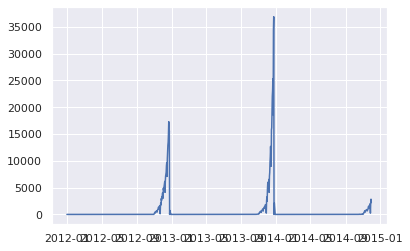

In [247]:
# parece conveniente comenzar desde inicios del 2012 para capturar mejor la periocidad anual
índice = pd.date_range(start='2012-01-01', end='2014-11-30', freq='D')

series = []

for id_pos, grupo in ventas.groupby('id_pos'):
    aux = grupo.groupby(level='fecha').unidades.sum()
    aux.name = id_pos
    series.append(aux.reindex(índice))

ventas = pd.concat(series, axis=1).fillna(0)

agregado = ventas.sum(axis=1)
sn.lineplot(data=agregado);

In [8]:
# recogidos a mano, inicios y fines de temporada
quiebres = ['2012-10-01','2012-12-30','2013-09-25','2013-12-29','2014-09-17']

In [37]:
agregado.name= 'y'
agregado.index.name = 'ds'

agregado = agregado.to_frame()
agregado['temporada'] = False

agregado.loc['2012-09-21':'2012-12-31', 'temporada'] = True
agregado.loc['2013-09-21':'2013-12-31', 'temporada'] = True
agregado.loc['2014-09-21':            , 'temporada'] = True

La actividad sucede por temporada entre finales de octubre, noviembre y diciembre. Además hay una estacionalidad semanal en la que los domingos es el día que menos se vende.

In [18]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [159]:
#changepoints=quiebres, changepoint_prior_scale=1, seasonality_mode='multiplicative'
m = Prophet(yearly_seasonality=False,
            changepoint_prior_scale=0.001,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode='multiplicative')

m.add_seasonality(name='semanal_en_temporada', period=7, fourier_order=5, condition_name='temporada', mode='additive')
m.add_seasonality(name='anual', period=365, fourier_order=20, mode='additive')

m.fit(agregado.reset_index());

In [160]:
future = m.make_future_dataframe(periods=31)

In [161]:
future['temporada'] = agregado.reset_index().temporada
future.temporada.fillna(True, inplace=True)

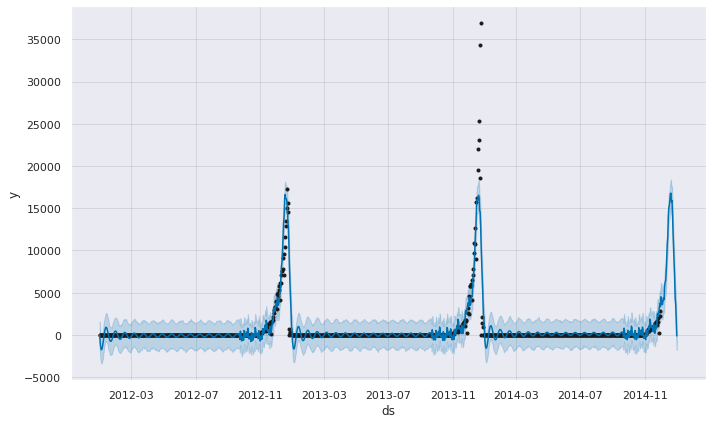

In [163]:
forecast = m.predict(future)
fig = m.plot(forecast)
#add_changepoints_to_plot(fig.gca(), m, forecast);

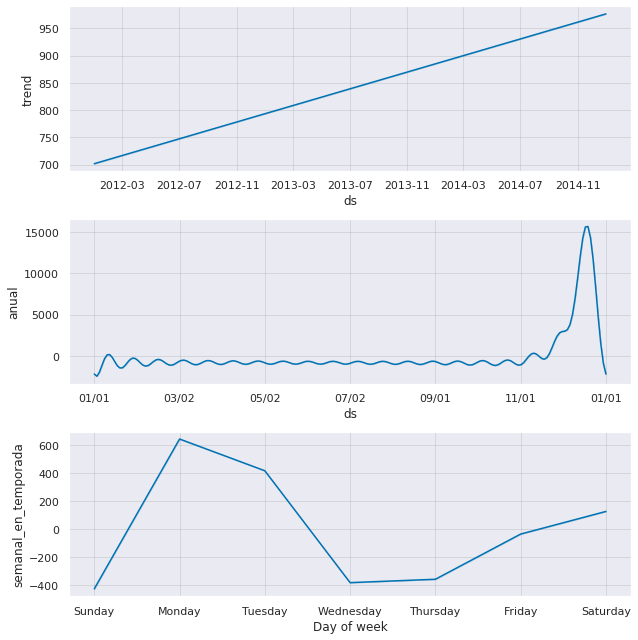

In [164]:
m.plot_components(forecast);

In [17]:
#wf = ventas.resample('W').sum()
#wf_corr = wf.corr()

## Puntos de venta

In [303]:
pos = pd.read_csv('pos.csv')
pos_válidos = pd.read_csv('ejemploRespuesta.csv', header=None, names=['id_pos','unidades'], usecols=['id_pos'])

import numpy as np
pos.id_pos = pd.to_numeric(pos.id_pos, errors='coerce')
pos.dropna(subset=['id_pos'], inplace=True)
pos.id_pos = pos.id_pos.astype(int)

posta = pd.merge(pos, pos_válidos, on='id_pos', how='right')

In [228]:
pd.merge(ventas, posta, on='id_pos').id_pos.nunique()

11825

In [124]:
agregado.loc['2012-01':'2012-11'].y.sum()

38271.0

In [125]:
agregado.loc['2013-01':'2013-11'].y.sum()

29841.0

In [126]:
agregado.loc['2014-01':'2014-11'].y.sum()

30537.0

In [129]:
agregado.loc['2012-12'].nlargest(5, 'y')

,y,temporada
ds,,
2012-12-22,17303.0,True
2012-12-24,15603.0,True
2012-12-21,15040.0,True
2012-12-23,14561.0,True
2012-12-20,13491.0,True


In [130]:
agregado.loc['2013-12'].nlargest(5, 'y')

,y,temporada
ds,,
2013-12-24,36882.0,True
2013-12-23,34363.0,True
2013-12-21,25286.0,True
2013-12-20,23093.0,True
2013-12-19,22032.0,True


In [129]:
agregado.loc['2012-12'].nlargest(5, 'y')

,y,temporada
ds,,
2012-12-22,17303.0,True
2012-12-24,15603.0,True
2012-12-21,15040.0,True
2012-12-23,14561.0,True
2012-12-20,13491.0,True


In [135]:
df.groupby(lambda x: x.year).any().sum(axis=1)

2012     7734
2013    11657
2014     5516
dtype: int64

In [145]:
df[df.index.month != 12].groupby(lambda x: x.year).any().sum(axis=1)

2012    4973
2013    5451
2014    5516
dtype: int64

In [146]:
df[df.index.month == 12].groupby(lambda x: x.year).any().sum(axis=1)

2012     7672
2013    11634
dtype: int64

### Estimador base

Lo mismo que vendieron el año anterior. Mejor dicho, lo que vendió cada punto de venta en 2013 sustrayendo lo que ya vendieron en 2014.

In [291]:
pred = (ventas.loc['2013'].sum() - ventas.loc['2014'].sum()).clip(lower=0).astype(int)

In [307]:
aux = posta.set_index('id_pos')
aux['unidades'] = pred

In [311]:
aux.unidades.fillna(0).astype(int).to_csv('p.csv', header=False)

### Estimador base mejorado

El MAE del estimador base es 12.97.

El `clip` no estuvo del todo bien. Las ventas negativas bien pueden deberse a que el punto de venta no existía en 2013.

In [337]:
vendieron_en_2013 = ventas.loc['2013'].sum() > 0
vendieron_en_2014 = ventas.loc['2014'].sum() > 0

In [357]:
aux = ventas.loc['2014'].sum()

aux.index.name = 'id_pos'
aux.name = 'unidades'

aux = aux.to_frame()
aux.head()

,unidades
id_pos,
3142,0.0
3143,0.0
3144,0.0
3146,0.0
3147,12.0


In [358]:
aux['activo'] = envíos.loc['2014'].sum() > 0

In [359]:
aux

,unidades,activo
id_pos,,
3142,0.0,True
3143,0.0,True
3144,0.0,True
3146,0.0,True
3147,12.0,True
3148,0.0,True
3150,0.0,True
3151,10.0,True
3152,0.0,True


In [335]:
aux['pred'] = ventas.loc['2013'].sum() - ventas.loc['2014'].sum()

In [342]:
envíos.groupby(lambda x: x.year)

,id_pos,unidades_despachadas
fecha,,
2012-08-17,5235,36
2012-08-24,4611,48
2012-08-24,4645,48
2012-08-24,4649,72
2012-08-24,4677,72
2012-08-24,4876,60
2012-08-24,4886,36
2012-08-24,4888,84
2012-08-24,4924,84


In [336]:
bien = vendieron_en_2013 & vendieron_en_2014 # clippear a cero

cerraron =  vendieron_en_2013 & ~vendieron_en_2014 #

abrieron = ~vendieron_en_2013 &  vendieron_en_2014 #


,unidades,pred
id_pos,,
3142,0.0,7.0
3143,0.0,49.0
3144,0.0,75.0
3146,0.0,7.0
3147,12.0,14.0


In [331]:
les_queda_por_vender_en_2014 = pred2 > 0
pred2[sí_vendieron_en_2014 & les_queda_por_vender_en_2014]

3147      14.0
3151      40.0
3154      36.0
3156      41.0
3157      28.0
3158     108.0
3163      65.0
3164      54.0
3166       7.0
3167      31.0
3168     117.0
3170      60.0
3172       8.0
3174      53.0
3176      45.0
3177      36.0
3179      88.0
3180      12.0
3182      18.0
3184     101.0
3185      15.0
3190      18.0
3196      50.0
3200      83.0
3201      85.0
3202       7.0
3203      34.0
3204      40.0
3207      16.0
3210      50.0
         ...  
34344      1.0
34375      4.0
34425      6.0
34446     22.0
34474      9.0
34483      9.0
34506     15.0
34510      1.0
34523     26.0
34530     16.0
34549     10.0
34567     15.0
34568      3.0
34609     20.0
34925     11.0
35045     20.0
35055     17.0
35182     11.0
36141      9.0
36880     42.0
37586     26.0
37821     10.0
38075     11.0
40347     11.0
40368     16.0
40383      3.0
40392      7.0
40455     81.0
40546     13.0
41618      4.0
Length: 4908, dtype: float64

In [325]:
pred2[no_vendieron_en_2013 & sí_vendieron_en_2014]

3187     -1.0
3393     -6.0
4124     -2.0
4166     -3.0
4461     -2.0
5451     -5.0
5476     -8.0
6151     -3.0
6552     -2.0
6567     -1.0
6994     -2.0
7392     -4.0
7888     -2.0
8228     -2.0
8249     -2.0
8262     -2.0
8267     -6.0
8321     -3.0
8338     -5.0
8339     -4.0
8340    -12.0
8370     -2.0
8376     -2.0
8383     -1.0
8399     -4.0
8410     -1.0
8419     -3.0
8439     -1.0
8440     -3.0
8461    -10.0
         ... 
18622    -6.0
18630    -1.0
18632    -5.0
18642    -3.0
18725    -1.0
18807   -22.0
18882    -6.0
18884    -1.0
18899    -9.0
32540   -13.0
32943   -11.0
33031    -1.0
34364    -3.0
34776    -1.0
41648    -2.0
42189    -8.0
42203    -5.0
42210    -2.0
42263    -2.0
42268    -5.0
42317    -3.0
42325   -12.0
42360    -2.0
42390    -1.0
42392    -1.0
42429    -1.0
42449    -1.0
42483    -1.0
42519    -1.0
42587    -2.0
Length: 481, dtype: float64

In [313]:
len(aux) * 13

167661

In [317]:
aux.unidades.isna().sum()

1044

In [145]:
df[df.index.month != 12].groupby(lambda x: x.year).any().sum(axis=1)

2012    4973
2013    5451
2014    5516
dtype: int64

In [145]:
df[df.index.month != 12].groupby(lambda x: x.year).any().sum(axis=1)

2012    4973
2013    5451
2014    5516
dtype: int64

In [269]:
len(pred)

12302

In [270]:
len(ampli)

12819

In [94]:


from sklearn.metrics import mean_absolute_error as MAE

https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

https://peerj.com/preprints/3190.pdf